# Chain-based sequence propagation in conductance-based LIF network

Demo of stable sequence propagation where strength of inhibitory feedback controls propagation speed.

In [8]:
%matplotlib inline
from copy import deepcopy as copy
import sys

import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from scipy.ndimage import gaussian_filter1d as smooth
from scipy.sparse import csc_matrix

from aux import Generic
from disp import set_font_size, set_color, set_n_x_ticks
from ntwk import LIFNtwkG, join_w

cc = np.concatenate

# PARAMS
## MODEL
M = {
    # E membrane dynamics
    'C_M_E': 1e-6, 'G_L_E': .1e-3, 'E_L_E': -0.05, 'V_TH_E': -0.036, 'V_R_E': -0.05, 'T_R_E': 0.002,
    # E architecture
    'N_E': 3000, 'N_X': 14, 'DX': .035,  # total E cells and chain params
    'W_E_E': .11e-3, 'W_MIN_E_E': .001e-4, 'L_E_E_F': 0.03,  # feed forward chain cxns
    'W_E_A': .15e-3,  # adaptation (represented by inhibitory autapses)
    
    # I membrane dynamics
    'C_M_I': 1e-6, 'G_L_I': .2e-3, 'E_L_I': -0.06, 'V_TH_I': -0.05, 'V_R_I': -0.06, 'T_R_I': 0.002,
    # I architecture
    'N_I': 750, 'P_I_E': .2, 'P_E_I': .2, 'W_I_E': 2e-6, 'W_E_I': 15e-6,  # interactions w E cells
    
    # synaptic reversal potentials & time constants
    'E_E': 0, 'E_I': -0.08, 'T_E': 0.002, 'T_I': 0.002,
    'E_A': -0.1, 'T_A': 0.01,  # adaptation 
}

## SMLN
S = {
    'RNG_SEED': 100, 'DT': 0.0005, 'D_SMLN': .4, 'N_TRIAL': 3,
    'TRG': {'T': 0.05, 'A': 8e-6, 'R': 0.001, 'D': 0.002, 'X': 0},
    'NOISE': .2e-6,
    'LESION_FRCS': np.arange(6, dtype=float) * .1,
}

print('TAU_M_E = {:.1f} ms'.format(M['C_M_E']/M['G_L_E'] * 1e3))
print('TAU_M_I = {:.1f} ms'.format(M['C_M_I']/M['G_L_I'] * 1e3))

TAU_M_E = 10.0 ms
TAU_M_I = 5.0 ms


$\tau^m_E = 10$ ms

$\tau^m_I = 5$ ms

$\tau_E = 2$ ms

$\tau_I = 2$ ms

Chain position assignment and connectivity

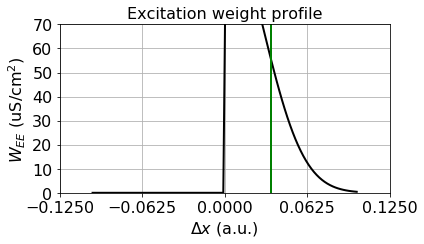

In [9]:
# connectivity funcs
def assign_x(dx, n_x, n, randomize):
    
    # number of layers
    n_l = int(round(n/n_x))
    
    # cells per layer
    n_xs = np.array([len(_) for _ in np.array_split(np.arange(n), n_l)])

    # interleave layer counts to prevent heavier layers bunching at start
    idx_c = np.nan * np.zeros(n_l)

    for n_x_ in np.unique(n_xs):
        mask = n_xs == n_x_
        idx_c[mask] = np.linspace(0, 1, mask.sum()+2)[1:-1]
    n_xs = n_xs[np.argsort(idx_c)]

    # assign x positions
    x = cc([np.repeat(dx*x_ctr, n_xs[x_ctr]) for x_ctr in range(len(n_xs))])
    
    if randomize:
        x = x[np.random.permutation(n)]
        
    return x

def make_w_e_e(x, m):
    """Make E-E weight mat w/ weight increasing w/ proxim."""
    n_e = m['N_E']
    
    # build distance matrix
    dx = np.tile(x[:, None], (1, n_e)) - np.tile(x[None, :], (n_e, 1))
    
    # build weight matrix
    ## decrease weights as squared exp of dist
    w = np.zeros(dx.shape)
    mask_f = dx >= 0  # forward cxns
    w[mask_f] = m['W_E_E'] * np.exp(-dx[mask_f]**2/(2*m['L_E_E_F']**2))
    ## set all weights below min weight th to 0
    w[w < m['W_MIN_E_E']] = 0
    
    return w

def make_w_i_e(m):
    """
    Make proximally biased E->I weight matrix.
    """
    n_i = m['N_I']
    n_e = m['N_E']
    
    # build weight matrix
    w_i_e = m['W_I_E'] * (np.random.rand(n_i, n_e) < m['P_I_E']).astype(float)
    return w_i_e
    
def make_w_e_i(m):
    """
    Make center-surround structured I->E weight matrix.
    """
    n_e = m['N_E']
    n_i = m['N_I']
    
    # build weight matrix
    w_e_i = m['W_E_I'] * (np.random.rand(n_e, n_i) < m['P_E_I']).astype(float)
    return w_e_i

def build_ntwk(m, s, w_r, x):
    """
    Construct a network object from the model and
    simulation params.
    """
    np.random.seed(s['RNG_SEED'])
    
    # set membrane properties
    n = m['N_E'] + m['N_I']
    
    c_m = cc(
        [np.repeat(m['C_M_E'], m['N_E']), np.repeat(m['C_M_I'], m['N_I'])])
    g_l = cc(
        [np.repeat(m['G_L_E'], m['N_E']), np.repeat(m['G_L_I'], m['N_I'])])
    e_l = cc(
        [np.repeat(m['E_L_E'], m['N_E']), np.repeat(m['E_L_I'], m['N_I'])])
    v_th = cc(
        [np.repeat(m['V_TH_E'], m['N_E']), np.repeat(m['V_TH_I'], m['N_I'])])
    v_r = cc(
        [np.repeat(m['V_R_E'], m['N_E']), np.repeat(m['V_R_I'], m['N_I'])])
    t_r = cc(
        [np.repeat(m['T_R_E'], m['N_E']), np.repeat(m['T_R_I'], m['N_I'])])
    
    # make ntwk
    ntwk = LIFNtwkG(
        c_m=c_m,
        g_l=g_l,
        e_l=e_l,
        v_th=v_th,
        v_r=v_r,
        t_r=t_r,
        e_s={'E': m['E_E'], 'I': m['E_I'], 'A': m['E_A']},
        t_s={'E': m['T_E'], 'I': m['T_I'], 'A': m['T_A']},
        w_r=join_w(targs_r, targs_r, w_r),
        w_u={'E': np.zeros((m['N_E'] + m['N_I'], 0))})  # no upstream spike inputs)
    
    ntwk.x = x
    
    ntwk.types_r = targs_r
    
    ntwk.n_e = m['N_E']
    ntwk.n_i = m['N_I']
    ntwk.n = m['N_E'] + m['N_I']
    
    return ntwk

def i_ext_trg(t, ntwk, m, s):
    """
    Add replay trigger to external current stim.
    """
    i_ext = np.zeros((len(t), m['N_E'] + m['N_I']))
    
    # get mask over cells to trigger to induce replay
    ## compute distances to trigger center
    dx = ntwk.x - s['TRG']['X']

    ## get mask
    trg_mask = (np.abs(dx) < s['TRG']['R']) & (ntwk.types_r == 'E')

    ## get time mask
    t_mask = (s['TRG']['T'] <= t) \
        & (t < (s['TRG']['T'] + s['TRG']['D']))

    ## add in external trigger
    i_ext[np.outer(t_mask, trg_mask)] = s['TRG']['A']

    return i_ext

# plot connectivity profile
dx = np.linspace(-.1, .1, 100)
w_e_e_plt = np.zeros(dx.shape)
mask_f = dx >= 0  # forward cxns
w_e_e_plt[mask_f] = M['W_E_E'] * np.exp(-dx[mask_f]**2/(2*M['L_E_E_F']**2))
## set all weights below min weight th to 0
w_e_e_plt[w_e_e_plt < M['W_MIN_E_E']] = 0

fig, ax = plt.subplots(1, 1, figsize=(6, 3.5), tight_layout=True)
ax.plot(dx, w_e_e_plt*1e6, c='k', lw=2)
ax.axvline(M['DX'], c='g', lw=2)
ax.set_ylim(0, 70)
ax.set_xlabel(r'$\Delta x$ (a.u.)')
ax.set_ylabel(r'$W_{EE}$ (uS/cm$^2$)')
ax.set_title('Excitation weight profile')
ax.grid()
set_n_x_ticks(ax, 5)
set_font_size(ax, 16)

## Simulation

In [12]:
alpha = .9
t = np.arange(0, S['D_SMLN'], S['DT'])
np.random.seed(S['RNG_SEED'])

# assign chain positions (x) to E cells
x_e = assign_x(M['DX'], M['N_X'], M['N_E'], randomize=True)
x = cc([x_e, np.zeros(M['N_I'])])
trg_mask_e = np.abs(x_e) < S['TRG']['R']

targs_r = cc([np.repeat('E', M['N_E']), np.repeat('I', M['N_I'])])

w_e_e_base = make_w_e_e(x[:M['N_E']], M)

w_i_e = make_w_i_e(M)
w_e_i = make_w_e_i(M)

w_e_a = M['W_E_A'] * np.eye(M['N_E'])

rslts_l = []  # lesioned results
rslts_r = []  # rescaled results

for lesion_frc in S['LESION_FRCS']:
    
    print('Running smlns for {:.1f}% ablation'.format(100*lesion_frc))
    
    w_e_e = w_e_e_base.copy()
    
    # ablate cells
    lesion = np.random.rand(M['N_E']) < lesion_frc
    w_e_e[:, (lesion & ~trg_mask_e)] = 0
    
    for rescale in [False, True]:
    
        # rescale synaptic input weights
        if rescale:
            scale = alpha * w_e_e_base.sum(axis=1) / w_e_e.sum(axis=1)
            w_e_e *= scale[:, None]

        w_r = {
            'E': {('E', 'E'): w_e_e, ('I', 'E'): w_i_e},
            'I': {('E', 'I'): w_e_i},
            'A': {('E', 'E'): w_e_a},
        }

        ntwk = build_ntwk(M, S, w_r, x)

        # build ntwk
        clamp = Generic(
            v={0: cc([np.repeat(M['E_L_E'], M['N_E']), np.repeat(M['E_L_I'], M['N_I'])])}, spk={})

        # loop over trials (w/ diff noise instantiations)
        rslts = []
        for tr_ctr in range(S['N_TRIAL']):

            # initialize external current array
            i_ext = S['NOISE'] * np.random.randn(len(t), M['N_E'] + M['N_I'])

            # add replay trigger
            i_ext += i_ext_trg(t, ntwk, M, S)

            # run smln
            rslt = ntwk.run(i_ext=i_ext, clamp=clamp, dt=S['DT'])

            # consolidate smln rslt
            rslt.ntwk = ntwk
            rslt.trg = S['TRG']

            rslt.m = M
            rslt.s = S
            rslts.append(copy(rslt))

        if not rescale:
            rslts_l.append(rslts)
        else:
            rslts_r.append(rslts)

Running smlns for 0.0% ablation
Running smlns for 10.0% ablation
Running smlns for 20.0% ablation
Running smlns for 30.0% ablation
Running smlns for 40.0% ablation
Running smlns for 50.0% ablation


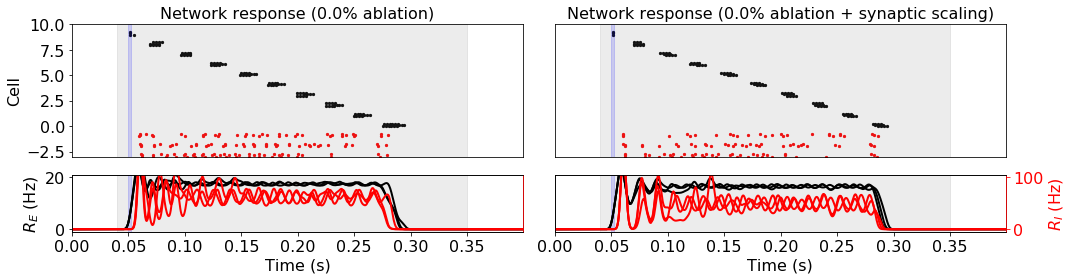

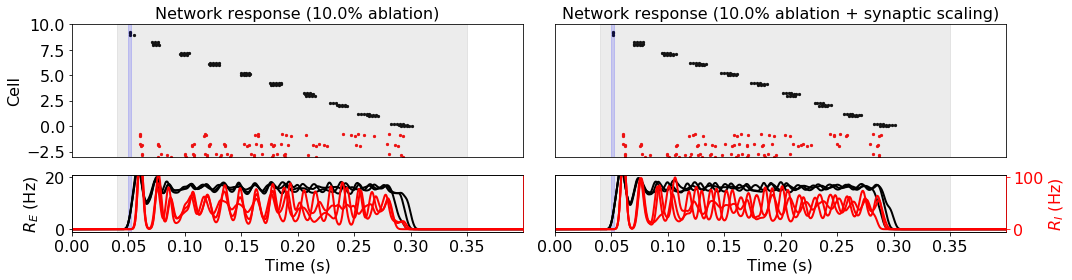

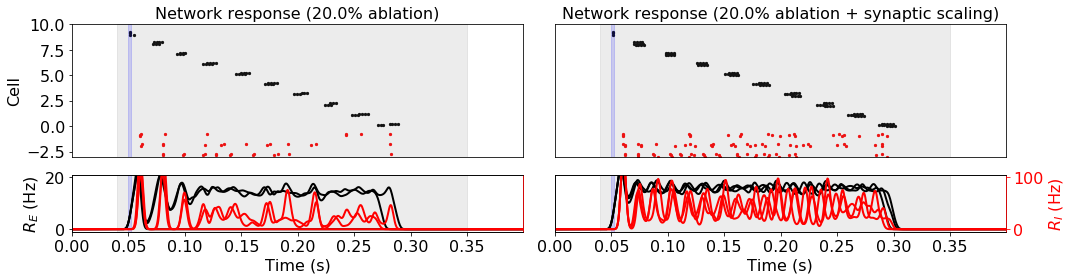

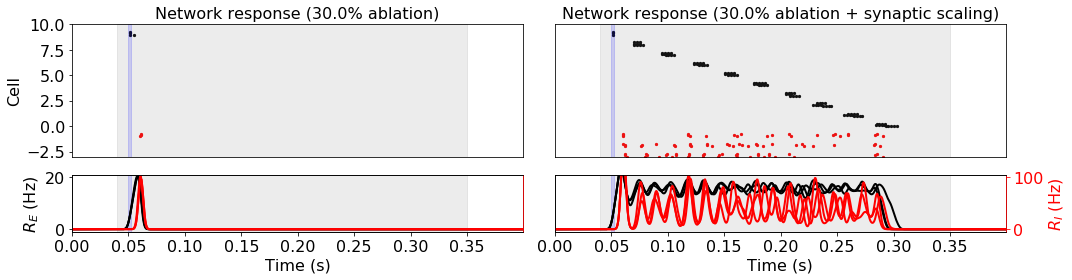

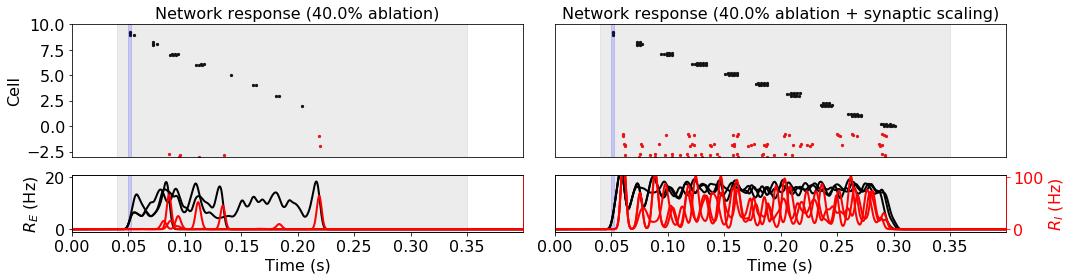

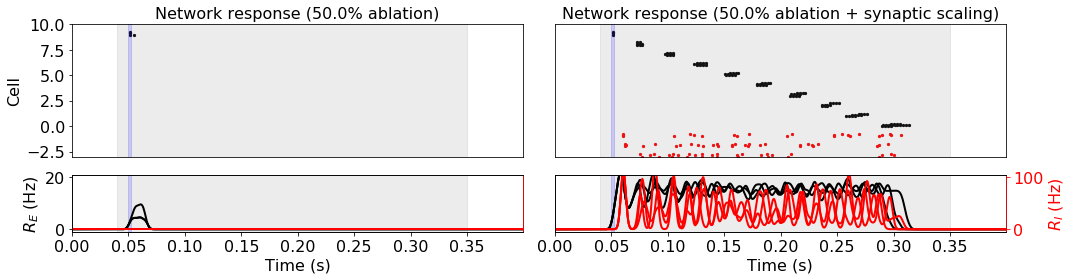

In [13]:
# make plots
X_RASTER = np.linspace(0, rslt.ntwk.x.max(), 10)[::-1]
EPOCH = (.04, .35)
STIM = (S['TRG']['T'], S['TRG']['T'] + S['TRG']['D'])

# plot funcs
def get_idxs_nearest(x_seq, x, nearest):
    """
    Get ordered idxs of place fields nearest to a sequence of xs.
    """
    idxs = []
    
    for x_ in x_seq:
        # get dists of all xs in x_seq to x
        dx = x - x_
        
        # add idxs of closest neurons to list
        idxs_ = list(np.abs(dx).argsort()[:nearest])
        idxs.extend(idxs_)
        
    return idxs

colors=np.zeros(len(X_RASTER))
cmap='inferno'
nearest=1
epoch=(0, 1)
smoothness=4
fig_size=(15, 4)
y_lim_raster = (-3, 10)
y_lim_fr_e = (-1, 21)
y_lim_fr_i = (-5, 105)

for lf_ctr, lf in enumerate(S['LESION_FRCS']):

    gs = gridspec.GridSpec(3, 2)
    fig = plt.figure(figsize=fig_size, tight_layout=True)

    # axes showing responses of lesioned ntwks
    axs_l = [None, None, None]
    axs_l[0] = fig.add_subplot(gs[:2, 0])
    axs_l[1] = fig.add_subplot(gs[2, 0])
    axs_l[2] = axs_l[1].twinx()

    # axes showing responses of lesioned-then-rescaled ntwks
    axs_r = [None, None, None]
    axs_r[0] = fig.add_subplot(gs[:2, 1])
    axs_r[1] = fig.add_subplot(gs[2, 1])
    axs_r[2] = axs_r[1].twinx()

    for col, (axs, rslts) in enumerate(zip([axs_l, axs_r], [rslts_l[lf_ctr], rslts_r[lf_ctr]])):

        # get ordered idxs of Es to plot
        e_mask = rslts[0].ntwk.types_r == 'E'
        x = rslts[0].ntwk.x[e_mask]

        ## loop through (x, y) pairs and add idxs of nearest Es
        e_idxs = get_idxs_nearest(X_RASTER, x, nearest)
        y_step = .35/len(rslts)

        for r_ctr, rslt in enumerate(rslts):
            # get all spks for selected Es
            spks_e_chosen = rslt.spks[:, e_idxs]

            # get desired time window
            if epoch == 'replay':
                start = 0
                end = rslt.schedule['D_SMLN']
            elif isinstance(epoch, tuple):
                start = epoch[0]
                end = epoch[1]

            t_mask = (start <= rslt.t) & (rslt.t < end)
            t_start = rslt.t[t_mask][0]

            spk_t_idxs, es = spks_e_chosen[t_mask].nonzero()
            spk_ts = spk_t_idxs * rslt.s['DT'] + t_start

            ## spks
            axs[0].scatter(spk_ts, es + y_step*r_ctr, c='k', s=5, vmin=0, vmax=1, cmap=cmap)

            axs[0].set_xlim(0, rslt.t[-1])

            set_font_size(axs[0], 16)

            # Es
            ## get spks
            spks_e = rslt.spks[:, :rslt.m['N_E']]

            # E population average
            axs[1].plot(rslt.t, smooth(spks_e.sum(axis=1) / (rslt.dt * rslt.m['N_E']), smoothness), c='k', lw=2)

            ## raster

            # Is
            # get spks
            spks_i = rslt.spks[:, -rslt.m['N_I']:]

            # raster
            t_idxs_spks_i, nrn_spks_i = spks_i[:, :3].nonzero()
            t_spks_i = t_idxs_spks_i * rslt.dt

            axs[0].scatter(t_spks_i, -nrn_spks_i - 1 + y_step*r_ctr, s=5, c='r')

            for tick_label, color in zip(axs[1].get_yticklabels(), ['r', 'k']):
                tick_label.set_color(color)

            # I population average
            axs[2].plot(rslt.t, smooth(spks_i.sum(axis=1) / (rslt.dt * rslt.m['N_I']), smoothness), c='r', lw=2)

        axs[0].set_ylim(y_lim_raster)
        axs[0].xaxis.set_visible(False)
        if col == 0:
            axs[0].set_ylabel('Cell')
            axs[0].set_title('Network response ({:.1f}% ablation)'.format(lf*100))
        elif col == 1:
            axs[0].yaxis.set_visible(False)
            axs[0].set_title('Network response ({:.1f}% ablation + synaptic scaling)'.format(lf*100))
        

        axs[1].set_ylim(y_lim_fr_e)
        axs[2].set_ylim(y_lim_fr_i)
        
        axs[1].set_xlabel('Time (s)')
        if col == 0:
            axs[1].set_ylabel(r'$R_E$ (Hz)')
            axs[2].yaxis.set_visible(False)
        elif col == 1:
            axs[1].yaxis.set_visible(False)
            axs[2].set_ylabel(r'$R_I$ (Hz)')
            
        set_color(axs[2], 'r')

        for ax in axs[:2]:
            ax.axvspan(*EPOCH, color='gray', alpha=0.15)
            ax.axvspan(*STIM, color='b', alpha=0.15)

        for ax in axs:
            ax.set_xlim(0, rslt.t[-1])
            set_font_size(ax, 16)

Comparison of E weight distributions pre-ablation, post-ablation, and post-recovery.

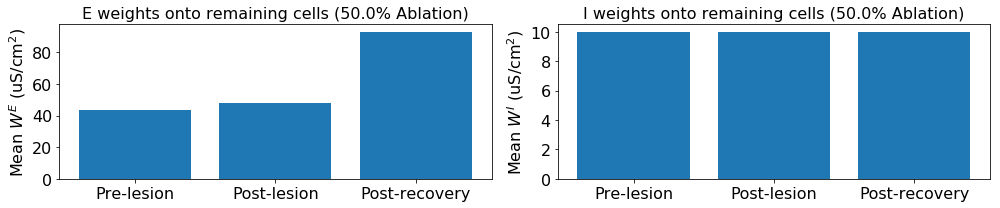

In [5]:
# pre-ablation E-E weights
w_e_pre = w_e_e_base.copy()

# post-recovery E-E weights
w_e_post = np.array(rslts_r[5][0].ntwk.w_r['E'].todense())[:M['N_E'], :M['N_E']]

silenced_mask = w_e_post.sum(0) == 0
silenced_mask.sum()

w_e_pre_ns = w_e_pre[~silenced_mask, :]
w_e_post_ns = w_e_post[~silenced_mask, :]

w_e_mean_0 = w_e_pre_ns[w_e_pre_ns > 0].mean()
w_e_mean_1 = w_e_post_ns[w_e_pre_ns > 0].mean()
w_e_mean_2 = w_e_post_ns[w_e_post_ns > 0].mean()

# pre-ablation I-E weights
w_i_pre = w_e_i.copy()

# post-recovery E-E weights
w_i_post = w_i_pre.copy()

silenced_mask = w_e_post.sum(0) == 0
silenced_mask.sum()

w_i_pre_ns = w_i_pre[~silenced_mask, :]
w_i_post_ns = w_i_post[~silenced_mask, :]

w_i_mean_0 = w_i_pre_ns[w_i_pre_ns > 0].mean()
w_i_mean_1 = w_i_post_ns[w_i_pre_ns > 0].mean()
w_i_mean_2 = w_i_post_ns[w_i_post_ns > 0].mean()

fig, axs = plt.subplots(1, 2, figsize=(14, 3), tight_layout=True)
axs[0].bar([0, 1, 2], 1e6 * np.array([w_e_mean_0, w_e_mean_1, w_e_mean_2]))
axs[0].set_xticks([0, 1, 2])
axs[0].set_xticklabels(['Pre-lesion', 'Post-lesion', 'Post-recovery'])
axs[0].set_ylabel('Mean $W^{E}$ (uS/cm$^2$)')
axs[0].set_title('E weights onto remaining cells ({:.1f}% Ablation)'.format(100*S['LESION_FRCS'][5]))

axs[1].bar([0, 1, 2], 1e6 * np.array([w_i_mean_0, w_i_mean_1, w_i_mean_2]))
axs[1].set_xticks([0, 1, 2])
axs[1].set_xticklabels(['Pre-lesion', 'Post-lesion', 'Post-recovery'])
axs[1].set_ylabel('Mean $W^{I}$ (uS/cm$^2$)')
axs[1].set_title('I weights onto remaining cells ({:.1f}% Ablation)'.format(100*S['LESION_FRCS'][5]))

for ax in axs:
    set_font_size(ax, 16)

$$W^{Pre}_{Sum} \equiv \sum_j W^{Pre}_j$$ 

$$W^{Post}_j \rightarrow \alpha W^{Post}_j$$

$$\sum_j \alpha W^{Post}_j = W^{Pre}_{Sum}$$ 